# Continuous Bag of Words Model

#### Libraries Import

In [1]:
import os
import time
import torch
import subprocess as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install datasets
from datasets import Dataset
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_path = sp.getoutput('git rev-parse --show-toplevel')
os.chdir(base_path)

from src import embed, pred_models, model_helpers

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nuriaadellraventos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preparation

#### Data Loading

In [4]:
# Get list of files in folder
folder_path = "data/"
file_list = os.listdir(folder_path)

# Create empty list to hold dataframes
df_list = []

# Loop through files in folder
for file in file_list:
    # Check if file is a CSV
    if file.endswith('.csv'):
        # Read CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file))
        # Append dataframe to list
        df_list.append(df)

# Concatenate all dataframes in list into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)

df.head()

,id,text,speaker,reply_to,conversation_id,case_id,speaker_type,side,timestamp,addressing,...,advocates_19_id,advocates_19_side,advocates_20_id,advocates_20_side,advocates_21_id,advocates_21_side,speaker_replied_to,speaker_type_replied_to,speaker_addressed,speaker_type_addressed
0,22620__0_002,"Well, isn't there something different here? Be...",j__david_h_souter,22620__0_001,22620,2005_04-433,J,NaN,162.447,22620__0_003,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
1,22620__0_003,"I don't agree, Justice Souter, and here's why....",david_c_frederick,22620__0_002,22620,2005_04-433,A,1.0,221.594,22620__0_004,...,NaN,NaN,NaN,NaN,NaN,NaN,j__david_h_souter,J,j__david_h_souter,J
2,22620__0_004,"Sure, but they suffered the harm because the f...",j__david_h_souter,22620__0_003,22620,2005_04-433,J,NaN,245.526,22620__0_005,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
3,22620__0_006,"Well, why... why is that true? Let's assume th...",j__anthony_m_kennedy,22620__0_005,22620,2005_04-433,J,NaN,326.156,22620__0_007,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A
4,22620__0_008,"Mr. Frederick, you... you started by saying ho...",j__ruth_bader_ginsburg,22620__0_007,22620,2005_04-433,J,NaN,409.067,22620__0_009,...,NaN,NaN,NaN,NaN,NaN,NaN,david_c_frederick,A,david_c_frederick,A


#### Select Top Justices

In [5]:
# Get judges columns
j_columns = [col for col in df.columns if col.startswith('votes_side_j_')]

count = 0
justices_list = []
justices_dict = {}

for justice in j_columns:
  df_j = df[['case_id', 'text'] + [justice]]
  grouped_df = df_j.groupby('case_id')['text'].apply(lambda x: ','.join(x)).reset_index()
  justices = df[["case_id"] + [justice]].drop_duplicates(keep='first')

  df1 = pd.merge(grouped_df, justices, left_on='case_id', right_on='case_id', how='left').dropna(axis='rows', how='any')
  df1 = df1.drop(df1[~df1[justice].isin([0, 1])].index)

  justices_dict[justice] = len(df1)



In [6]:
# Sorted justices by case load
sorted_justices_by_case = sorted(justices_dict.items(), key=lambda x:x[1], reverse=True)
sorted_justices_by_case

[('votes_side_j__ruth_bader_ginsburg', 1390),
 ('votes_side_j__clarence_thomas', 1387),
 ('votes_side_j__stephen_g_breyer', 1376),
 ('votes_side_j__anthony_m_kennedy', 1264),
 ('votes_side_j__antonin_scalia', 1090),
 ('votes_side_j__john_g_roberts_jr', 1003),
 ('votes_side_j__samuel_a_alito_jr', 969),
 ('votes_side_j__john_paul_stevens', 741),
 ('votes_side_j__sonia_sotomayor', 710),
 ('votes_side_j__david_h_souter', 665),
 ('votes_side_j__elena_kagan', 605),
 ('votes_side_j__sandra_day_oconnor', 388),
 ('votes_side_j__william_h_rehnquist', 365),
 ('votes_side_j__neil_gorsuch', 195),
 ('votes_side_j__brett_m_kavanaugh', 115),
 ('votes_side_j__abe_fortas', 0),
 ('votes_side_j__arthur_j_goldberg', 0),
 ('votes_side_j__byron_r_white', 0),
 ('votes_side_j__charles_e_whittaker', 0),
 ('votes_side_j__earl_warren', 0),
 ('votes_side_j__felix_frankfurter', 0),
 ('votes_side_j__harold_burton', 0),
 ('votes_side_j__harry_a_blackmun', 0),
 ('votes_side_j__hugo_l_black', 0),
 ('votes_side_j__john_

In [7]:
# Get top justices
top_justices = [justice for justice, votes in sorted_justices_by_case[:15]]
print(top_justices)

['votes_side_j__ruth_bader_ginsburg', 'votes_side_j__clarence_thomas', 'votes_side_j__stephen_g_breyer', 'votes_side_j__anthony_m_kennedy', 'votes_side_j__antonin_scalia', 'votes_side_j__john_g_roberts_jr', 'votes_side_j__samuel_a_alito_jr', 'votes_side_j__john_paul_stevens', 'votes_side_j__sonia_sotomayor', 'votes_side_j__david_h_souter', 'votes_side_j__elena_kagan', 'votes_side_j__sandra_day_oconnor', 'votes_side_j__william_h_rehnquist', 'votes_side_j__neil_gorsuch', 'votes_side_j__brett_m_kavanaugh']


### Case Outcome Predictions

#### Datasets

In [8]:
# Have to do by utterance as grouping by case_id gives too few examples to learn from
df_all = df[['win_side', 'text', 'case_id']]
df_all.head()

# Keep only cases with outcomes 0 or 1
df_all = df_all[df_all.win_side.isin([0, 1])]

In [9]:
# Get unique case_ids
unique_case_ids = df_all['case_id'].unique()

# Split the unique case_ids into training and testing sets
train_case_ids, val_test_case_ids = train_test_split(unique_case_ids, test_size=0.2, random_state=123)
val_case_ids, test_case_ids = train_test_split(val_test_case_ids, test_size=0.5, random_state=123)

# Filter the original dataframe to create the train and test dataframes using the train and test case_ids
train_df = df_all[df_all['case_id'].isin(train_case_ids)]
val_df = df_all[df_all['case_id'].isin(val_case_ids)]
test_df = df_all[df_all['case_id'].isin(test_case_ids)]

In [13]:
# Data Loaders
BATCH_SIZE = 128
vocab_size = 300 # Size of GloVe vectors

train_dataloader = DataLoader(Dataset.from_pandas(train_df.drop(columns=['case_id']), preserve_index = False), batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=embed.collate_into_cbow)
valid_dataloader = DataLoader(Dataset.from_pandas(val_df.drop(columns=['case_id']), preserve_index = False), batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=embed.collate_into_cbow)
test_dataloader = DataLoader(Dataset.from_pandas(test_df.drop(columns=['case_id']), preserve_index = False), batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=embed.collate_into_cbow)

#### Training

In [25]:
# BoW NN Classifier
hidden_dim = 1000
model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)

At iteration 1000 the train loss is 0.599.
After epoch 1 the validation loss is 0.643.
At iteration 1000 the train loss is 0.633.
After epoch 2 the validation loss is 0.644.
At iteration 1000 the train loss is 0.645.
After epoch 3 the validation loss is 0.643.
At iteration 1000 the train loss is 0.636.
After epoch 4 the validation loss is 0.645.
At iteration 1000 the train loss is 0.630.
After epoch 5 the validation loss is 0.647.
At iteration 1000 the train loss is 0.635.
After epoch 6 the validation loss is 0.650.
At iteration 1000 the train loss is 0.586.
After epoch 7 the validation loss is 0.651.
At iteration 1000 the train loss is 0.670.
After epoch 8 the validation loss is 0.651.
At iteration 1000 the train loss is 0.693.
After epoch 9 the validation loss is 0.652.
At iteration 1000 the train loss is 0.634.
After epoch 10 the validation loss is 0.653.
At iteration 1000 the train loss is 0.624.
After epoch 11 the validation loss is 0.657.
At iteration 1000 the train loss is 0.647

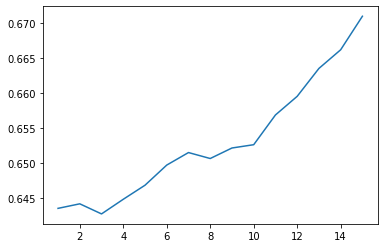

In [26]:
EPOCHS = 15
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_model = None
best_val_loss = float('inf')
val_losses = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function, print_val=True)
    val_y_true, val_y_pred = model_helpers.make_predictions(model, valid_dataloader)
    val_loss = log_loss(val_y_true.astype(np.float64), val_y_pred.astype(np.float64))
    if val_loss < best_val_loss:
        best_model = type(model)(model.vocab_size, model.hidden_dim, model.output_dim)
        best_model.load_state_dict(model.state_dict())
        best_val_loss = val_loss
    val_losses.append(val_loss)
    time_taken = time.time() - epoch_start_time
    print(f'After epoch {epoch} the validation loss is {val_loss:.3f}.')

plt.plot(range(1, EPOCHS+1), val_losses)

Best Threshold=0.661855, G-Mean=0.499


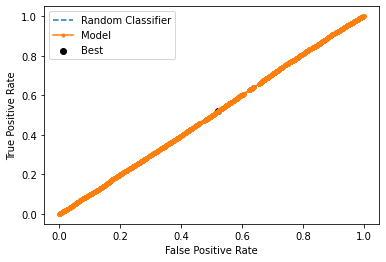

In [27]:
# Get validation predictions to select best threshold
val_labels, val_probs = model_helpers.make_predictions(model, valid_dataloader)
# Get best threshold from validation data
threshold = model_helpers.select_threshold(val_labels, val_probs)

#### Evaluation

In [28]:
# Get dataframe with predictions and real values
test_results_df = model_helpers.get_test_results_df(best_model, test_dataloader, test_df[['case_id', 'win_side']])
test_results_df.head()

,case_id,win_side,labels,prob
766,2005_04-1739,1.0,1.0,0.670836
767,2005_04-1739,1.0,1.0,0.739240
768,2005_04-1739,1.0,1.0,0.603128
769,2005_04-1739,1.0,1.0,0.659513
770,2005_04-1739,1.0,1.0,0.690952


In [29]:
# Results dataframe per utterance
per_utterance_df = (test_results_df
                    .assign(pred=lambda x: x['prob']
                    .apply(lambda y: 1 if y > threshold else 0)))

# Results dataframe per case
per_case_df = (test_results_df
                .groupby('case_id')
                .mean()
                .assign(pred=lambda x: x['prob']
                .apply(lambda y: 1 if y > threshold else 0)))

In [31]:
# Evaluation metrics per utterance
model_helpers.get_evaluation_matrix(per_utterance_df['win_side'], per_utterance_df['pred'])

{'f1': 0.41992799907095574,
 'roc_auc': 0.49516505073023553,
 'accuracy': 0.45033379796053113}

In [34]:
# Evaluation metrics per case
model_helpers.get_evaluation_matrix(per_case_df['win_side'], per_case_df['pred'])

{'f1': 0.2385321100917431,
 'roc_auc': 0.5122222222222222,
 'accuracy': 0.40714285714285714}

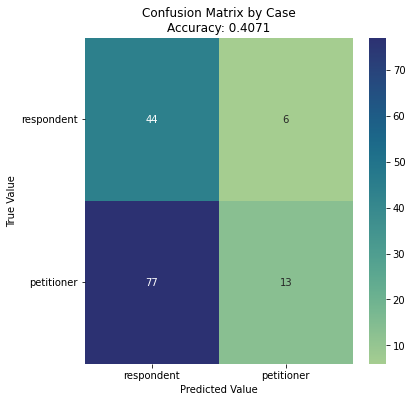

In [35]:
# Confusion matrix by case
model_helpers.results_heatmap(per_case_df['win_side'],
                per_case_df['pred'],
                'Confusion Matrix by Case',
                target_names = ['respondent', 'petitioner'])

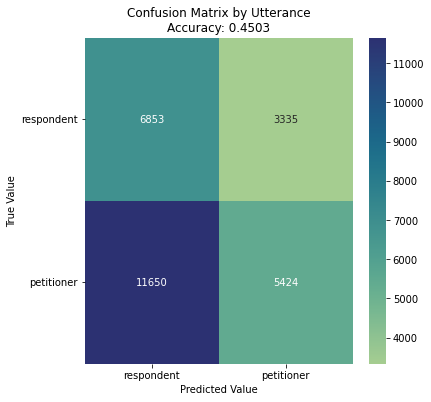

In [36]:
# Confusion matrix by utterance
model_helpers.results_heatmap(per_utterance_df['win_side'],
                per_utterance_df['pred'],
                'Confusion Matrix by Utterance',
                target_names = ['respondent', 'petitioner'])

### Justice Outcome Predictions

In [20]:
top_justices

['votes_side_j__ruth_bader_ginsburg',
 'votes_side_j__clarence_thomas',
 'votes_side_j__stephen_g_breyer',
 'votes_side_j__anthony_m_kennedy',
 'votes_side_j__antonin_scalia',
 'votes_side_j__john_g_roberts_jr',
 'votes_side_j__samuel_a_alito_jr',
 'votes_side_j__john_paul_stevens',
 'votes_side_j__sonia_sotomayor',
 'votes_side_j__david_h_souter',
 'votes_side_j__elena_kagan',
 'votes_side_j__sandra_day_oconnor',
 'votes_side_j__william_h_rehnquist',
 'votes_side_j__neil_gorsuch',
 'votes_side_j__brett_m_kavanaugh']

In [ ]:
# Set parameters, loss function and optimizer
vocab_size = 300
BATCH_SIZE = 64
EPOCHS = 15
hidden_dim = 500
loss_function = torch.nn.BCELoss()

for justice in top_justices:

    print("Running model for: ", justice)

    # Have to do by utterance as grouping by case_id gives too few examples to learn from
    df_j = df[[justice, 'text', 'case_id']]
    df_j.head()

    # Keep only cases with outcomes 0 or 1
    df_j = df_j[df_j[justice].isin([0, 1])]

    # Get unique case_ids
    unique_case_ids = df_j['case_id'].unique()
    # Split the unique case_ids into training and testing sets
    train_case_ids, val_test_case_ids = train_test_split(unique_case_ids, test_size=0.2, random_state=123)
    val_case_ids, test_case_ids = train_test_split(val_test_case_ids, test_size=0.5, random_state=123)

    # Filter the original dataframe to create the train and test dataframes using the train and test case_ids
    train_df = df_j[df_j['case_id'].isin(train_case_ids)]
    val_df = df_j[df_j['case_id'].isin(val_case_ids)]
    test_df = df_j[df_j['case_id'].isin(test_case_ids)]

    # Data loaders
    train_dataloader = DataLoader(Dataset.from_pandas(train_df.drop(columns=['case_id']), preserve_index = False), batch_size=BATCH_SIZE,
                                shuffle=True,
                                collate_fn=lambda batch: embed.collate_into_cbow(batch, justice))
    valid_dataloader = DataLoader(Dataset.from_pandas(val_df.drop(columns=['case_id']), preserve_index = False), batch_size=BATCH_SIZE,
                                shuffle=False, 
                                collate_fn=lambda batch: embed.collate_into_cbow(batch, justice))
    test_dataloader = DataLoader(Dataset.from_pandas(test_df.drop(columns=['case_id']), preserve_index = False), batch_size=BATCH_SIZE,
                                shuffle=False, 
                                collate_fn=lambda batch: embed.collate_into_cbow(batch, justice))
    
    # BoW NN Classifier
    model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train model
    print("Start training...")
    best_model = None
    best_val_loss = float('inf')
    val_losses = []
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function)
        val_y_true, val_y_pred = model_helpers.make_predictions(model, valid_dataloader)
        val_loss = log_loss(val_y_true.astype(np.float64), val_y_pred.astype(np.float64))
        if val_loss < best_val_loss:
            best_model = type(model)(model.vocab_size, model.hidden_dim, model.output_dim)
            best_model.load_state_dict(model.state_dict())
            best_val_loss = val_loss
        val_losses.append(val_loss)
        time_taken = time.time() - epoch_start_time
        print(f'After epoch {epoch} the validation loss is {val_loss:.3f}.')
    
    # Get validation predictions to select best threshold
    val_labels, val_probs = model_helpers.make_predictions(model, valid_dataloader)
    # Get best threshold from validation data
    threshold = model_helpers.select_threshold(val_labels, val_probs)

    # Model evaluation
    print("Start test evaluation...")
    # Get dataframe with predictions and real values
    test_results_df = model_helpers.get_test_results_df(best_model, test_dataloader, test_df[['case_id', justice]])

    # Results dataframe per utterance
    per_utterance_df = (test_results_df
                        .assign(pred=lambda x: x['prob']
                        .apply(lambda y: 1 if y > threshold else 0)))

    # Results dataframe per case
    per_case_df = (test_results_df
                    .groupby('case_id')
                    .mean()
                    .assign(pred=lambda x: x['prob']
                    .apply(lambda y: 1 if y > threshold else 0)))
    
    # Evaluation metrics per utterance
    eval_metrics = model_helpers.get_evaluation_matrix(per_utterance_df[justice], per_utterance_df['pred'])
    print("Per utterance: ", eval_metrics)

    # Evaluation metrics per case
    eval_metrics_case = model_helpers.get_evaluation_matrix(per_case_df[justice], per_case_df['pred'])
    print("Per case: ", eval_metrics_case)

